##### Universidade Federal de São Carlos - UFSCar <br>Centro de Ciências Exatas e Tecnólogicas - CCET

# Trabalho de Graduação A
### Uma abordagem estatística sobre a estimação de _redshifts_ de quasares usando dados do S-PLUS

Discente: Gabriela Pereira Soares<br>Orientador: Rafael Izbicki<br>Co-orientadora: Lilianne Nakazono

Fevereiro de 2021

In [1]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats
import flexcode
import warnings
from flexcode.regression_models import RandomForest
from flexcode.regression_models import XGBoost
from flexcode.regression_models import NN
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.patches as mpatches
%matplotlib inline

Vamos carregar o mesmo conjunto de dados utilizado na pesquisa de Raquel para que o experimento seja comparável.

In [7]:
caminho = "C:/Users/Gabriela/Documents/TG/Análises Preliminares/database/"

# Carregando os dados de treinamento
trainfold0 = pd.read_csv(caminho+"trainfold0.csv", low_memory=False)
trainfold1 = pd.read_csv(caminho+"trainfold1.csv", low_memory=False)
trainfold2 = pd.read_csv(caminho+"trainfold2.csv", low_memory=False)
trainfold3 = pd.read_csv(caminho+"trainfold3.csv", low_memory=False)
trainfold4 = pd.read_csv(caminho+"trainfold4.csv", low_memory=False)

# Carregando os dados de validação
validationfold0 = pd.read_csv(caminho+"validationfold0.csv", low_memory=False)
validationfold1 = pd.read_csv(caminho+"validationfold1.csv", low_memory=False)
validationfold2 = pd.read_csv(caminho+"validationfold2.csv", low_memory=False)
validationfold3 = pd.read_csv(caminho+"validationfold3.csv", low_memory=False)
validationfold4 = pd.read_csv(caminho+"validationfold4.csv", low_memory=False)

# Carregando a amostra de teste
test = pd.read_csv(caminho+"test.csv", low_memory=False)

In [184]:
print(len(trainfold0),len(validationfold0),len(test))

16413 4104 6840


In [8]:
# Concatenando os datasets para obter o conjunto completo
dados = pd.concat([trainfold0,validationfold0,test])

In [9]:
dados.head()

,index,Field,ID,RA_1,DEC_1,X,Y,ISOarea,MU_MAX,A,...,J0410_iso-r_iso,J0430_iso-r_iso,J0515_iso-r_iso,r_iso-J0660_iso,r_iso-J0861_iso,r_iso-W1_MAG,r_iso-W2_MAG,FUVmag-r_iso,NUVmag-r_iso,Zclass
0,35844,STRIPE82-0163,iDR3.STRIPE82-0163.035411,353.801826,-0.482775,8962.2810,6922.2110,12,17.508287,1.320163,...,0.592438,1.358313,0.111649,-0.061876,-0.692299,4.705591,5.889046,0.567219,-0.258181,2
1,25926,STRIPE82-0125,iDR3.STRIPE82-0125.048006,326.841560,-0.369219,9166.1550,7665.5225,4,17.009247,1.334710,...,-0.225453,1.010672,0.496397,-0.126772,0.390370,4.144383,4.467175,NaN,NaN,4
2,18869,STRIPE82-0060,iDR3.STRIPE82-0060.003444,41.635591,0.091411,2009.9844,1516.8861,35,16.349241,1.692433,...,0.373749,0.096077,0.125700,-0.032084,-0.011645,3.713305,4.999304,NaN,NaN,2
3,3047,STRIPE82-0011,iDR3.STRIPE82-0011.008800,6.670586,-1.163833,8223.1670,2464.2346,9,17.234804,1.535165,...,0.254142,0.419345,0.850948,-0.114995,0.314160,3.152518,5.045413,NaN,NaN,2
4,32829,STRIPE82-0152,iDR3.STRIPE82-0152.033297,345.323720,0.765429,8792.9930,5928.9526,9,17.711014,1.117999,...,1.047352,1.523887,0.219181,0.152403,0.417545,4.629427,5.581610,NaN,NaN,3


In [9]:
# Alterando a nomenclatura das colunas
def replace_all(dados, dic):
    cols = dados.columns.values
    for i, j in dic.items():
        cols = [w.replace(i, j) for w in cols]
    return cols

dic = {'F378':'J0378', 'F395':'J0395', 'F410':'J0410', 'F430':'J0430', 
       'F515':'J0515', 'F660':'J0660', 'F861':'J0861', 'r_iso':'R_iso',
       'u_iso':'U_iso','g_iso':'G_iso','i_iso':'I_iso','z_iso':'Z_iso'}

dados.columns = replace_all(dados,dic)

In [8]:
dados.shape

(27357, 625)

No total, temos 27.357 linhas e 625 colunas. As linhas contemplam o dataset original já tratado, ou seja, considerando as observações com $0 < r\_iso < 22$ e $0 < z < 7$. As colunas também incluem variáveis de cor criadas e a classificação do _redshift_ (?).

In [10]:
# Verificando o intervalo da banda r_iso e do redshift Z
pd.concat([dados['r_iso'].describe(),dados['Z'].describe()], axis=1)

,r_iso,Z
count,27335.000000,27357.000000
mean,20.718616,1.621008
std,0.922937,0.757056
min,15.399064,0.034357
25%,20.173191,1.058147
50%,20.889393,1.538000
75%,21.446664,2.090000
max,21.999947,6.999202


Vamos fazer uma análise descritiva das principais variáveis no banco de dados, que são as magnitudes do S-PLUS, WISE e GALEX, seus respectivos erros e o redshift Z. A principal abertura que iremos analisar é a abertura isofótica, por apresentar resultados melhores em pesquisas anteriores. Porém as outras aberturas também serão avaliadas ao longo do estudo.

In [56]:
def iqr_outlier_boundary(df, k=1.5):
    
    outs = np.zeros(shape=(2,len(df.columns)))
    
    for i in range(df.shape[1]):
        q1 = df.iloc[:,i].quantile(0.25)
        q3 = df.iloc[:,i].quantile(0.75)
        iqr = q3 - q1
        outs[0,i] = q1-k*iqr
        outs[1,i] = q3+k*iqr
    
    return pd.DataFrame(outs,columns=df.columns)

In [10]:
apers = ["auto", "aper_3", "aper_6", "iso", "petro", "PStotal"] # aberturas
feat_broad = ['U', 'G', 'R', 'I', 'Z'] # banda larga
feat_narrow = ['J0378', 'J0395', 'J0410', 'J0430', 'J0515', 'J0660', 'J0861'] # banda estreita

feat = feat_broad+feat_narrow
splus_aper = []
splus_iso = [item+"_iso" for item in feat]

for a in apers:
    splus_aper = splus_aper + [item+"_"+a for item in feat]

# Magnitudes
wise = ["W1_MAG", "W2_MAG"]
galex = ['FUVmag', 'NUVmag']

# Erros
error_splus = ["e_"+item for item in splus_aper]
error_iso = ["e_"+item for item in splus_iso]
error_wise = [item+"_ERR" for item in wise]
error_galex = ["e_"+item for item in galex]

In [11]:
cols=splus_iso+wise+galex
dados[cols].describe()

,U_iso,G_iso,R_iso,I_iso,Z_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,J0515_iso,J0660_iso,J0861_iso,W1_MAG,W2_MAG,FUVmag,NUVmag
count,26213.000000,27347.000000,27335.000000,27355.000000,27350.000000,26075.000000,25322.000000,25913.000000,26349.000000,27002.000000,27293.000000,27138.000000,27072.000000,26955.000000,3618.000000,9705.000000
mean,21.718498,21.094590,20.718616,20.504942,20.350146,21.472781,21.344388,21.337572,21.263177,21.043031,20.767463,20.496598,16.543784,15.466508,21.381903,21.265999
std,1.298349,1.005644,0.922937,0.934624,0.956597,1.281213,1.278683,1.249019,1.230193,1.138898,1.019406,1.066663,1.050298,1.089562,0.894702,0.947314
min,15.693669,15.546192,15.399064,15.110929,14.914334,15.586912,15.553884,15.505044,15.484595,15.560777,15.433805,15.018042,10.570083,9.603073,16.002700,16.042100
25%,20.925241,20.489469,20.173191,19.948298,19.786834,20.698516,20.569222,20.588250,20.526245,20.368664,20.160458,19.864320,15.920853,14.827140,20.908325,20.704900
50%,21.732521,21.236340,20.889393,20.642134,20.462140,21.480019,21.308716,21.333685,21.271751,21.104723,20.888712,20.561314,16.580088,15.497491,21.522550,21.386500
75%,22.451235,21.807513,21.446664,21.192151,21.005415,22.196167,22.041687,22.025726,21.954077,21.726707,21.474611,21.148804,17.196137,16.115449,22.026700,21.965800
max,33.947880,33.175200,21.999947,27.712261,26.905193,34.631280,29.321917,33.050335,34.014053,35.604820,35.095410,29.125994,24.925806,26.437078,23.128900,23.390800


In [59]:
# Far Outlier Boundary
iqr_outlier_boundary(dados[cols],k=3)

,U_iso,G_iso,R_iso,I_iso,Z_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,J0515_iso,J0660_iso,J0861_iso,W1_MAG,W2_MAG,FUVmag,NUVmag
0,16.347259,16.535339,16.352772,16.216741,16.131092,16.205563,16.151826,16.275822,16.242749,16.294536,16.217999,16.010867,12.095002,10.962215,17.553200,16.9222
1,27.029217,25.761644,25.267083,24.923708,24.661158,26.689120,26.459083,26.338154,26.237573,25.800835,25.417070,25.002257,21.021988,19.980374,25.381825,25.7485


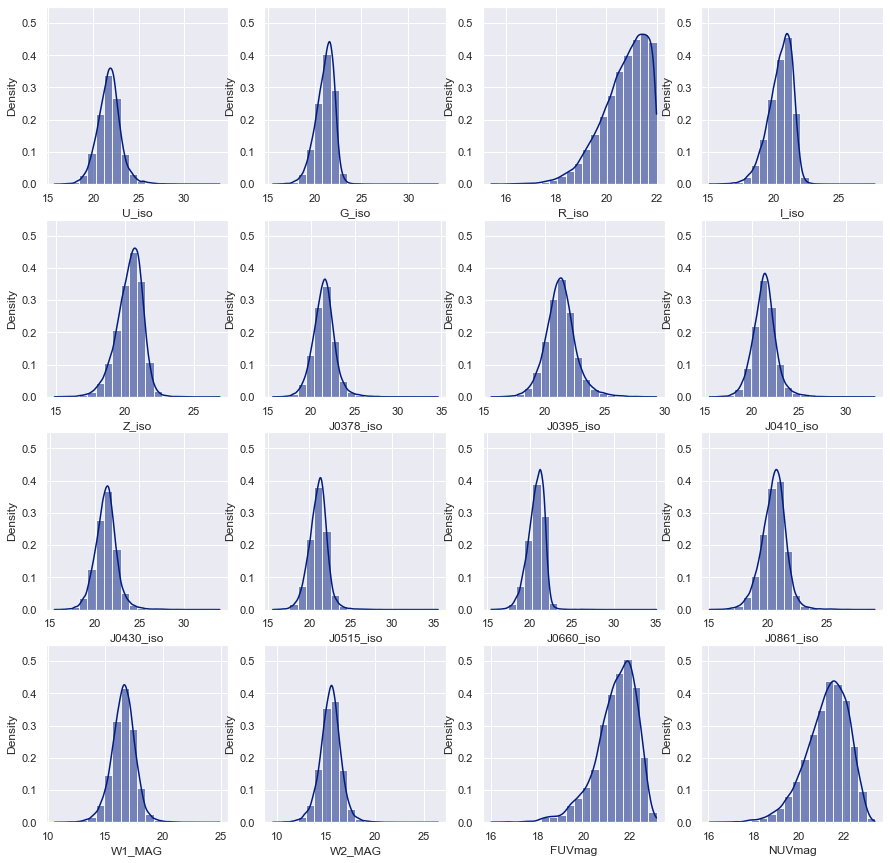

In [84]:
# Histogramas
# mudar fundo 
sns.set(context="notebook", style="darkgrid", palette="dark")

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
dic = {0:axs[0,0], 1:axs[0,1], 2:axs[0,2], 3:axs[0,3],
       4:axs[1,0], 5:axs[1,1], 6:axs[1,2], 7:axs[1,3],
       8:axs[2,0], 9:axs[2,1],10:axs[2,2],11:axs[2,3],
      12:axs[3,0],13:axs[3,1],14:axs[3,2],15:axs[3,3]}

for i in range(16):
    sns.histplot(data=dados[cols[i]], bins=20, kde=True, stat='density', ax=dic[i]).set(ylim=(0, 0.55))
plt.show()

Vemos que a maioria das magnitudes apresentam distribuições simétricas, com mais _outliers_ à direita, com exceção da FUVmag, NUVmag e a banda R, que apresentam grande assimetria à esquerda. Vale lembrar que o formato da distribuição da banda R se deve possívelmente ao fato de termos "cortado" os valores acima de 22.

In [12]:
errs = error_iso+error_wise+error_galex
dados[errs].describe()

,e_U_iso,e_G_iso,e_R_iso,e_I_iso,e_Z_iso,e_J0378_iso,e_J0395_iso,e_J0410_iso,e_J0430_iso,e_J0515_iso,e_J0660_iso,e_J0861_iso,W1_MAG_ERR,W2_MAG_ERR,e_FUVmag,e_NUVmag
count,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27357.000000,27255.000000,27138.000000,3618.000000,9705.000000
mean,2.089474,0.355928,0.107635,0.110678,0.186953,4.423482,2.583124,2.654314,4.911167,3.999481,2.403460,0.585219,0.128700,0.269161,0.312237,0.257561
std,83.540220,37.197589,0.653186,0.509637,0.487284,359.507272,9.828208,69.708839,390.351751,497.899934,351.180404,6.406496,1.576107,15.333802,0.111715,0.117882
min,0.004455,0.002842,0.002763,0.003202,0.005163,0.006565,0.010110,0.008187,0.007541,0.007193,0.003548,0.007738,-1.000000,-1.000000,0.019100,0.010400
25%,0.127317,0.059704,0.051677,0.060241,0.097148,0.164218,0.240837,0.202749,0.179470,0.136220,0.059800,0.129945,0.038328,0.053264,0.227750,0.161400
50%,0.228622,0.098984,0.083435,0.095891,0.152016,0.288477,0.418890,0.348887,0.307420,0.226289,0.097304,0.207396,0.071387,0.099708,0.317600,0.250600
75%,0.432939,0.148187,0.120900,0.138537,0.220931,0.549904,0.859421,0.660975,0.545666,0.366991,0.145073,0.319530,0.126991,0.177300,0.398475,0.351800
max,13716.097000,6151.826000,23.759700,76.967285,29.657766,58164.530000,886.580800,9400.486000,57049.360000,82242.670000,58072.383000,737.459300,171.717830,2521.752400,0.542700,0.499800


In [60]:
# Far Outlier Boundary
iqr_outlier_boundary(dados[errs],k=3)

,e_U_iso,e_G_iso,e_R_iso,e_I_iso,e_Z_iso,e_J0378_iso,e_J0395_iso,e_J0410_iso,e_J0430_iso,e_J0515_iso,e_J0660_iso,e_J0861_iso,W1_MAG_ERR,W2_MAG_ERR,e_FUVmag,e_NUVmag
0,-0.789550,-0.205746,-0.155993,-0.174648,-0.27420,-0.992841,-1.614914,-1.171928,-0.919119,-0.556091,-0.196019,-0.438809,-0.227662,-0.318844,-0.284425,-0.4098
1,1.349806,0.413636,0.328570,0.373426,0.59228,1.706963,2.715172,2.035652,1.644255,1.059302,0.400893,0.888284,0.392982,0.549408,0.910650,0.9230


In [44]:
dados[dados['e_U_iso']>1.3][['e_U_iso','U_iso']]

,e_U_iso,U_iso
7,22.281271,NaN
9,21.532503,NaN
13,22.638533,NaN
24,1.782871,24.377981
42,5.104546,25.611784
...,...,...
6814,22.532530,NaN
6819,1.324127,23.916199
6822,26.716550,27.380892
6827,3.900125,24.501730


**Pergunta: Por que temos erros tão grandes (_outliers_)? É por causa das bandas com valores grandes? O erro aumenta à medida que o valor da magnitude cresce? Tem algo relacionado com as _missings bands_?**

In [94]:
# Um caso do erro com valor extremo
dados.loc[dados["e_U_iso"] > 13716, cols]

,U_iso,G_iso,R_iso,I_iso,Z_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,J0515_iso,J0660_iso,J0861_iso,W1_MAG,W2_MAG,FUVmag,NUVmag
5175,33.94788,21.342657,21.130348,21.314491,20.514355,22.681349,NaN,21.971113,21.900698,21.245708,20.98304,21.069418,17.816738,NaN,NaN,NaN


Vamos ver a distribuição do _redshift_ como um todo. Aqui, mostramos também que a proporção de valores do _redshift_ é mantida para cada conjunto de dados.

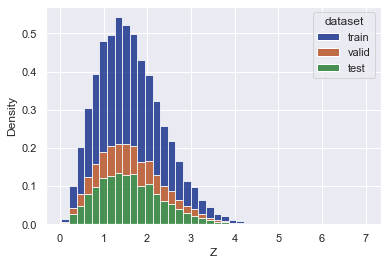

In [235]:
dados_z = pd.DataFrame({'Z':dados["Z"].values, 'dataset':dados["dataset"].values})
sns.set(context="notebook", style="darkgrid", palette="dark")
sns.histplot(dados_z,x="Z", hue="dataset",multiple="stack", bins=40, stat="density")
plt.show()

Agora vamos analisar o _redshift_ e ver também como os valores _missing_ nas magnitudes impactam em sua distribuição.

C:\Users\Gabriela\AppData\Local\Temp/ipykernel_7700/1114668618.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([p1,p2],     # The line objects


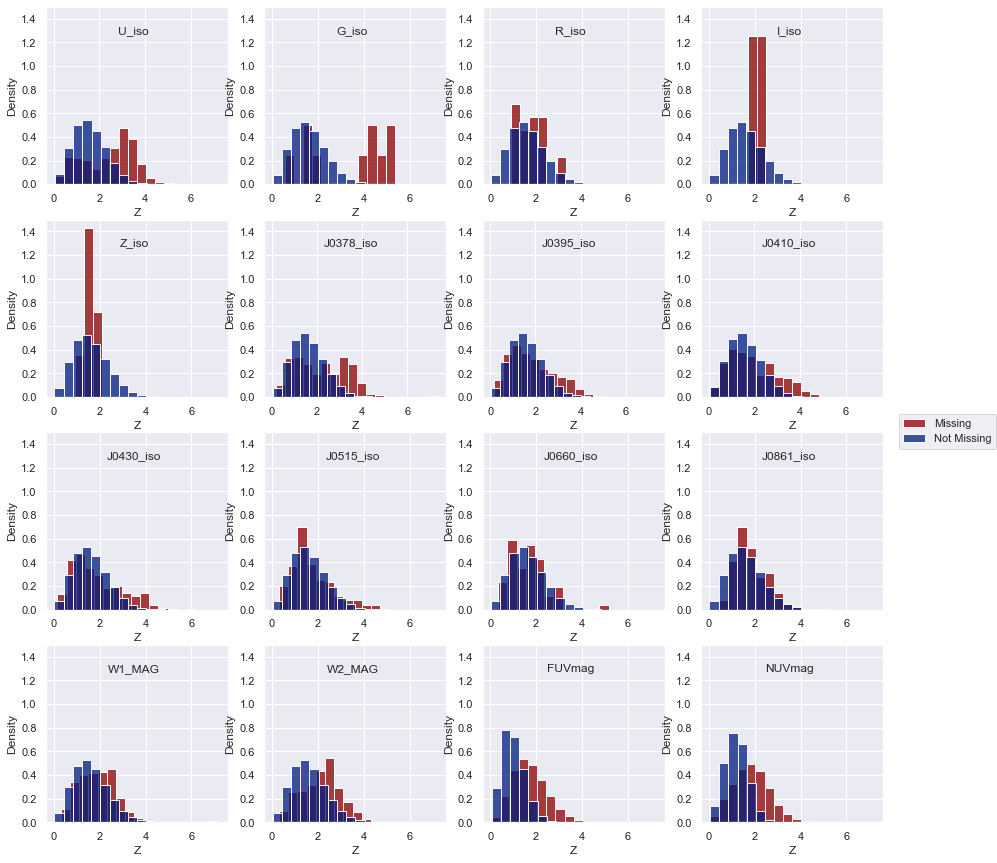

In [181]:
# Construir um gráfico do valor do redshift cuja cor é azul se nao é missing e vermelho se pelo menos uma banda é missing
sns.set(context="notebook", style="darkgrid", palette="dark")

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
dic = {0:axs[0,0], 1:axs[0,1], 2:axs[0,2], 3:axs[0,3],
       4:axs[1,0], 5:axs[1,1], 6:axs[1,2], 7:axs[1,3],
       8:axs[2,0], 9:axs[2,1],10:axs[2,2],11:axs[2,3],
      12:axs[3,0],13:axs[3,1],14:axs[3,2],15:axs[3,3]}
mis = dados[cols].isna()

for i in range(16):
    p1=sns.histplot(data=dados.loc[mis[cols[i]] == True]["Z"],color="darkred",
                    binwidth=0.4, stat='density', ax=dic[i]).set(ylim=(0, 1.5))
    p2=sns.histplot(data=dados.loc[mis[cols[i]] == False]["Z"],binwidth=0.4, 
                    stat='density', ax=dic[i])
    dic[i].text(3.5,1.3, cols[i], ha="center", va="center")
    
fig.legend([p1,p2],     # The line objects
           labels=["Missing","Not Missing"],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           )    
# red_patch = mpatches.Patch(color='darkred', label='Missing')
# blue_patch = mpatches.Patch(color='darkblue', label='Not Missing')
# plt.legend(handles=[red_patch, blue_patch])
plt.show()

Aqui, vemos que a distribuição do _redshift_ como um todo tende a se deslocar para a direita quando há valores faltantes em alguma banda, indicando que valores _missing_ nas magnitudes influenciam à maiores valores de _redshift_, principalmente em relação às bandas do GALEX e as bandas U_iso e G_iso.

Podemos ver também como as observações _missing_ se correlacionam.

In [242]:
cols2=error_splus+error_wise+error_galex+splus_aper+galex+wise
df_na = dados[cols2].isna().sum().to_frame("Contagem")
df_na["%"] = df_na["Contagem"]/dados[cols2].shape[0] 
df_na.loc[df_na["%"]!=0].sort_values(by="%", ascending=False)

,Contagem,%
e_FUVmag,23739,0.867749
FUVmag,23739,0.867749
e_NUVmag,17652,0.645246
NUVmag,17652,0.645246
J0395_iso,2035,0.074387
J0410_iso,1444,0.052784
J0378_iso,1282,0.046862
U_iso,1144,0.041817
J0430_iso,1008,0.036846
W2_MAG,402,0.014695


<AxesSubplot:>

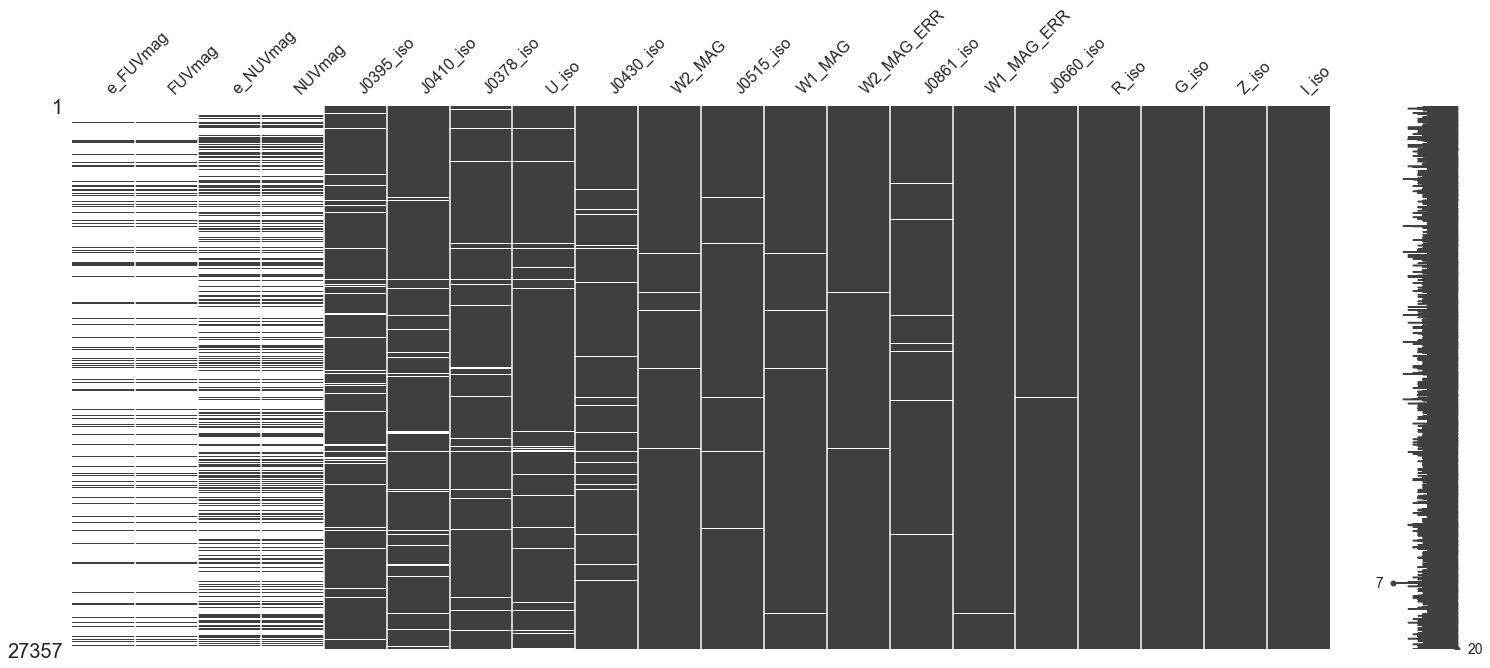

In [243]:
import missingno as msno
msno.matrix(dados[df_na.loc[df_na["%"]!=0].sort_values(by="%", ascending=False).index])

**Não sei se isso é informativo (?)**, mas percebemos uma relação entre os valores _missing_ das bandas do GALEX e seus respectivos erros, ou seja, quando há dados faltantes nas magnitudes, também haverá nos erros. Os demais não parecem ter relação.

**Lembrando que os dados faltantes serão substituíduos pelo valor 99, dado que eles possivelmente trazem informação a respeito do _redshift_, e também a falta de informação tem uma justificativo física-astronômica**

<AxesSubplot:ylabel='Density'>

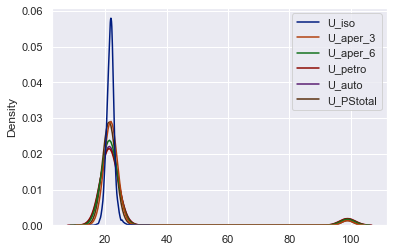

In [66]:
sns.kdeplot(data=dados[["U_iso","U_aper_3","U_aper_6","U_petro","U_auto","U_PStotal"]])

(10.0, 40.0)

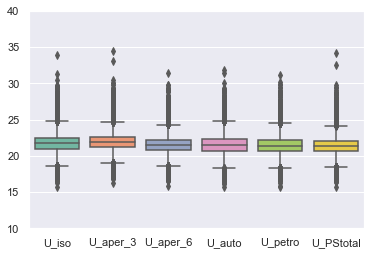

In [254]:
sns.boxplot(data=dados[["U_iso","U_aper_3","U_aper_6","U_auto","U_petro","U_PStotal"]], orient="v", palette="Set2")
plt.ylim(10, 40)

Aparentemente, a distribuição dos dados considerando a banda U e diferentes aberturas parece ser a mesma. Assim, faz-se desnecessário analisar todas as aberturas. Consideraremos isso como verdade para as demais bandas. <br> **OBS.:** Possivelmente isso deve ter algum sentido de imageamento, dado que é a mesma banda e estamos apenas mudando a abertura.

Uma vez que nosso interesse principal é nos filtros de banda estreita, poderíamos explorar uma análise bivariada entre esse filtros e o _redshift_.

**Pergunta: Faz sentido analisar a relação entre cada banda estreita e o _redshift_?**

C:\Users\Gabriela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


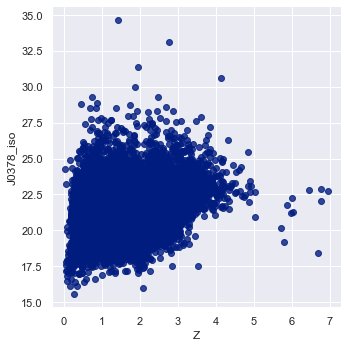

In [259]:
# Scatter Plot
narrow=[item+"_iso" for item in feat_narrow]
sns.lmplot('Z', narrow[0], data = dados, fit_reg = False)

<AxesSubplot:>

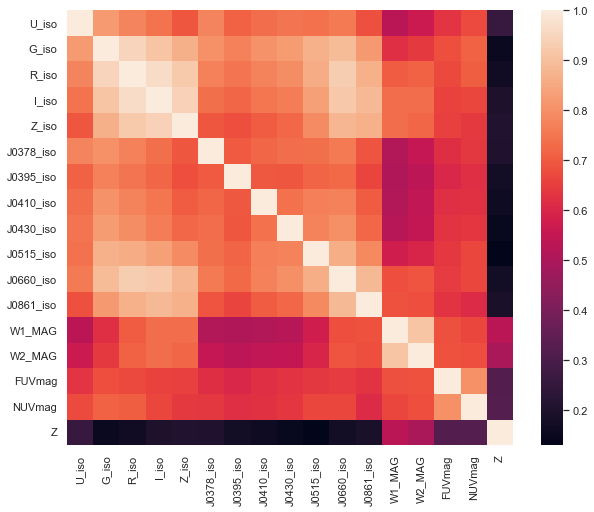

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dados[cols+["Z"]].corr())

Aparentemente, os filtros de banda estreita possuem baixíssima correlação com o _redshift_. Em contrapartida, as bandas entre si aparentam ter moderada correlação. **Pergunta: caso questionem, isso não será um problema na modelagem?**